# Appendix A: K-Means customer segmentation case study 

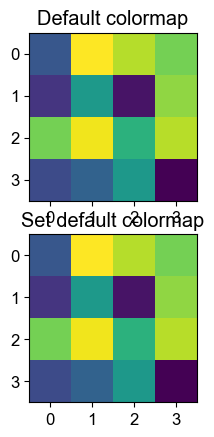

In [1]:
import os
import random
import sys
import time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append(os.path.join(os.path.abspath(".."), "code"))
from plotting_functions import *

DATA_DIR = os.path.join(os.path.abspath(".."), "data/")
from sklearn import cluster, datasets, metrics
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
# from support_functions import *
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

#plt.style.use("seaborn")

plt.rcParams["font.size"] = 16

### What is customer segmentation? 

- Understand landscape of the market in businesses and craft targeted business or marketing strategies tailored for each group.

<img src="../img/customer-segmentation.png" alt="" height="600" width="600"> 

[source](https://www.youtube.com/watch?v=zPJtDohab-g&t=134s)

Check out [this interesting talk by Malcom Gladwell](https://www.ted.com/talks/malcolm_gladwell_on_spaghetti_sauce?language=en). Humans are diverse and there is no single spaghetti sauce that would make all of them happy! 

Often it's beneficial to businesses to explore the landscape of the market and tailor their services and products offered to each group. This is called **customer segmentation**. It's usually applied when the dataset contains some of the following features. 

- **Demographic information** such as gender, age, marital status, income, education, and occupation
- **Geographical information** such as specific towns or counties or a customer's city, state, or even country of residence (in case of big global companies)
- **Psychographics** such as social class, lifestyle, and personality traits
- **Behavioral data** such as spending and consumption habits, product/service usage, and desired benefits 

### Business problem 

- Imagine that you are hired as a data scientist at a bank. They provide some data of their credit card customers to you. 
- Their goal is to develop customized marketing campaigns and they ask you to group customers based on the given information. 
- Now that you know about K-Means clustering, let's apply it to the dataset to group customers. 

### Data

- We will use the [Credit Card Dataset for clustering](https://www.kaggle.com/arjunbhasin2013/ccdata) from Kaggle.
- Download the data and save the CSV under the `data` folder. 
- I encourage you to work through this case study on your own. 

In [2]:
creditcard_df = pd.read_csv(DATA_DIR + "CC General.csv")
creditcard_df.shape

(8950, 18)

### Information of the dataset 

We have behavioral data. 

- CUSTID: Identification of Credit Card holder
- BALANCE: Balance amount left in customer's account to make purchases
- BALANCE_FREQUENCY: How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)
- PURCHASES: Amount of purchases made from account
- ONEOFFPURCHASES: Maximum purchase amount done in one-go
- INSTALLMENTS_PURCHASES: Amount of purchase done in installment
- CASH_ADVANCE: Cash in advance given by the user
- PURCHASES_FREQUENCY: How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased)
- ONEOFF_PURCHASES_FREQUENCY: How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased)
- PURCHASES_INSTALLMENTS_FREQUENCY: How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)
- CASH_ADVANCE_FREQUENCY: How frequently the cash in advance being paid
- CASH_ADVANCE_TRX: Number of Transactions made with "Cash in Advance"
- PURCHASES_TRX: Number of purchase transactions made
- CREDIT_LIMIT: Limit of Credit Card for user
- PAYMENTS: Amount of Payment done by user
- MINIMUM_PAYMENTS: Minimum amount of payments made by user
- PRC_FULL_PAYMENT: Percent of full payment paid by user
- TENURE: Tenure of credit card service for user

### Preliminary EDA

In [3]:
creditcard_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

- All numeric features
- Some missing values

In [4]:
creditcard_df.describe()

BALANCE  BALANCE_FREQUENCY     PURCHASES  ONEOFF_PURCHASES  \
count   8950.000000        8950.000000   8950.000000       8950.000000   
mean    1564.474828           0.877271   1003.204834        592.437371   
std     2081.531879           0.236904   2136.634782       1659.887917   
min        0.000000           0.000000      0.000000          0.000000   
25%      128.281915           0.888889     39.635000          0.000000   
50%      873.385231           1.000000    361.280000         38.000000   
75%     2054.140036           1.000000   1110.130000        577.405000   
max    19043.138560           1.000000  49039.570000      40761.250000   

       INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
count             8950.000000   8950.000000          8950.000000   
mean               411.067645    978.871112             0.490351   
std                904.338115   2097.163877             0.401371   
min                  0.000000      0.000000             0.000000   
25%                  0.000000      0.000000             0.083333   
50%                 89.000000      0.000000             0.500000   
75%                468.637500   1113.821139             0.916667   
max              22500.000000  47137.211760             1.000000   

       ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
count                 8950.000000                       8950.000000   
mean                     0.202458                          0.364437   
std                      0.298336                          0.397448   
min                      0.000000                          0.000000   
25%                      0.000000                          0.000000   
50%                      0.083333                          0.166667   
75%                      0.300000                          0.750000   
max                      1.000000                          1.000000   

       CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
count             8950.000000       8950.000000    8950.000000   8949.000000   
mean                 0.135144          3.248827      14.709832   4494.449450   
std                  0.200121          6.824647      24.857649   3638.815725   
min                  0.000000          0.000000       0.000000     50.000000   
25%                  0.000000          0.000000       1.000000   1600.000000   
50%                  0.000000          0.000000       7.000000   3000.000000   
75%                  0.222222          4.000000      17.000000   6500.000000   
max                  1.500000        123.000000     358.000000  30000.000000   

           PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT       TENURE  
count   8950.000000       8637.000000       8950.000000  8950.000000  
mean    1733.143852        864.206542          0.153715    11.517318  
std     2895.063757       2372.446607          0.292499     1.338331  
min        0.000000          0.019163          0.000000     6.000000  
25%      383.276166        169.123707          0.000000    12.000000  
50%      856.901546        312.343947          0.000000    12.000000  
75%     1901.134317        825.485459          0.142857    12.000000  
max    50721.483360      76406.207520          1.000000    12.000000

### Practice exercises for you

1. What is the average `BALANCE` amount?
2. How often the `BALANCE_FREQUENCY` is updated on average? 
3. Obtain the row the customer who made the maximum cash advance transaction. 

<br><br><br><br>

### Mini exercises for you (Answers)

1. What is the average `BALANCE` amount? 1564.47
2. How often the `BALANCE_FREQUENCY` is updated on average? 0.877 (pretty often) 
3. Obtain the row of the customer who made the maximum cash advance transaction. 

In [5]:
# Answer 3.
max_cash_advance = creditcard_df["CASH_ADVANCE"].max()
creditcard_df[creditcard_df["CASH_ADVANCE"] == max_cash_advance]

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
2159  C12226  10905.05381                1.0     431.93             133.5   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
2159                  298.43   47137.21176             0.583333   

      ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
2159                        0.25                               0.5   

      CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
2159                     1.0               123             21       19600.0   

         PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
2159  39048.59762       5394.173671               0.0      12

Let's examine correlations between features. 

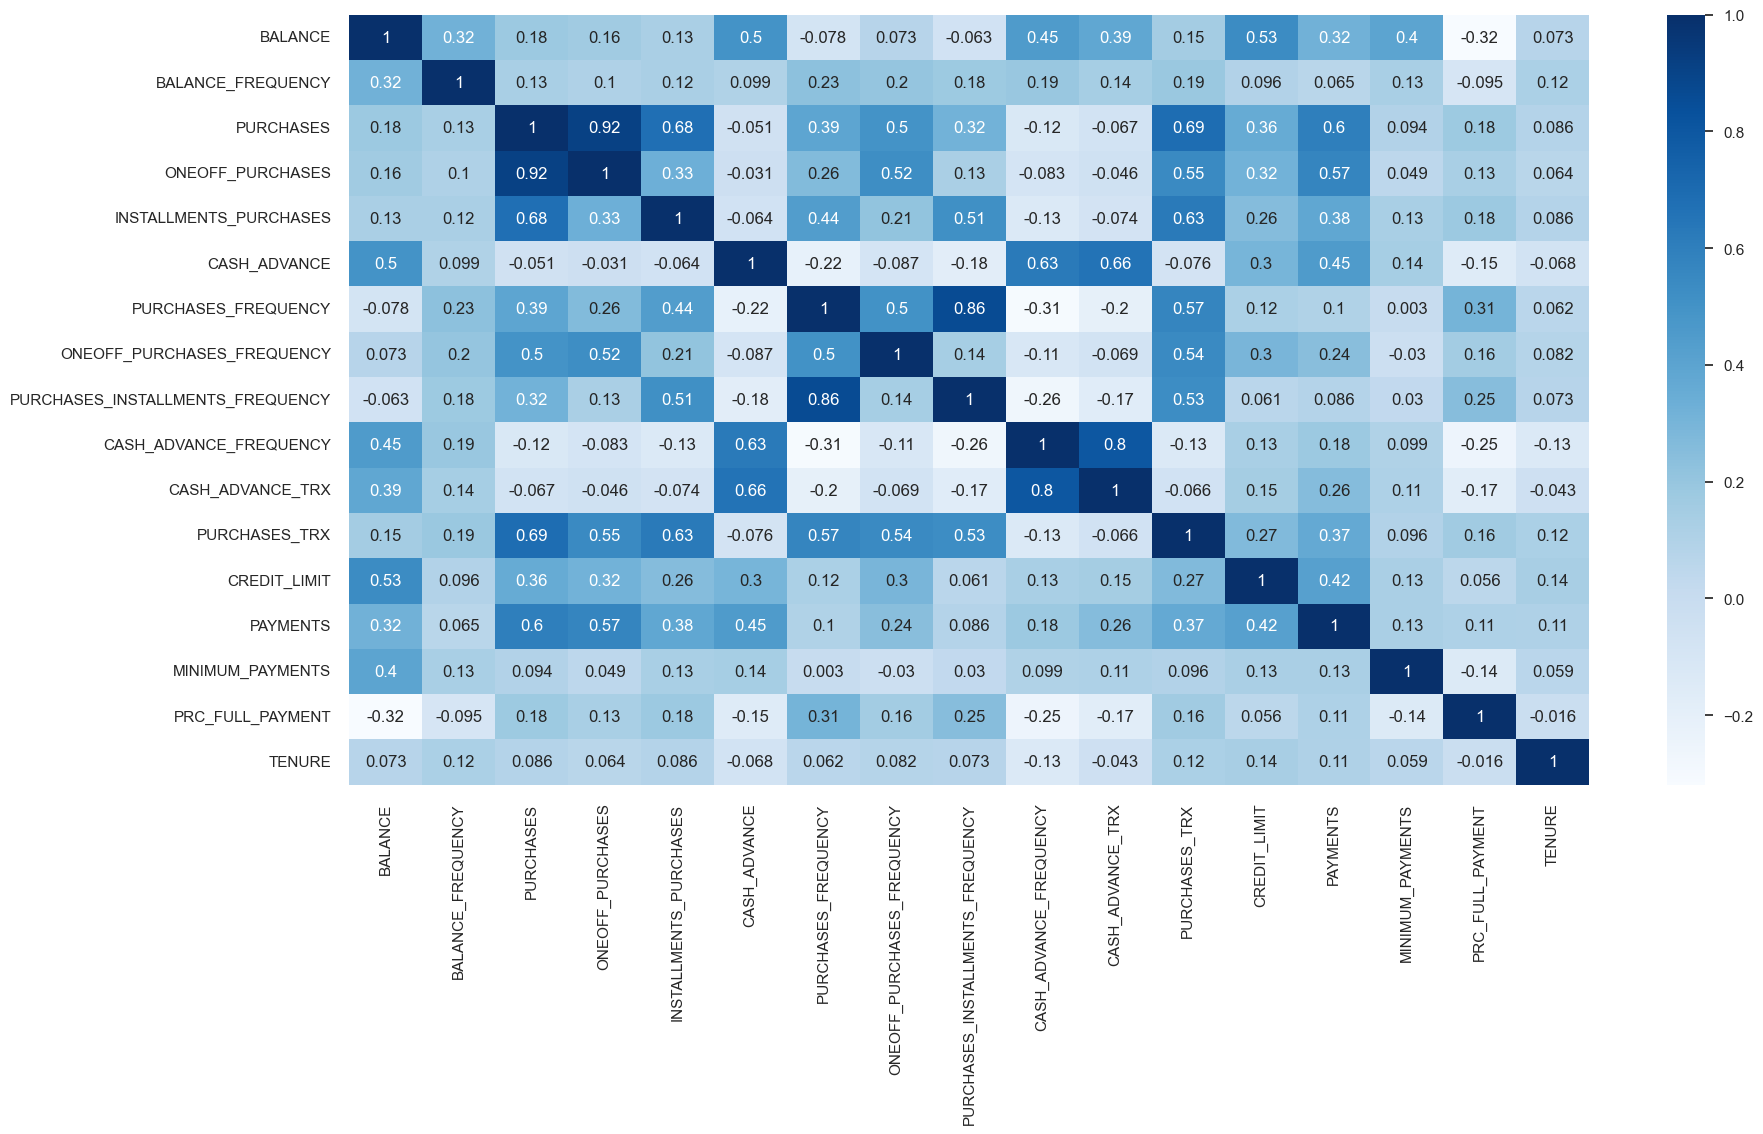

In [7]:
cor = creditcard_df.corr(numeric_only=True)
plt.figure(figsize=(20, 10))
sns.set(font_scale=1)
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues);

### Feature types and preprocessing 

Let's identify different feature types and transformations 

In [11]:
creditcard_df.columns

Index(['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE'],
      dtype='object')

In [12]:
drop_features = ["CUST_ID"]
numeric_features = list(set(creditcard_df.columns) - set(drop_features))

In [13]:
from sklearn.impute import SimpleImputer

numeric_transformer = make_pipeline(SimpleImputer(), StandardScaler())

preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features), ("drop", drop_features)
)

In [14]:
transformed_df = pd.DataFrame(
    data=preprocessor.fit_transform(creditcard_df), columns=numeric_features
)

In [15]:
transformed_df

PURCHASES_TRX  INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES  \
0         -0.511333               -0.349079     -0.466786  -0.424900   
1         -0.591796               -0.454576      2.605605  -0.469552   
2         -0.109020               -0.454576     -0.466786  -0.107668   
3         -0.551565               -0.454576     -0.368653   0.232058   
4         -0.551565               -0.454576     -0.466786  -0.462063   
...             ...                     ...           ...        ...   
8945      -0.350408               -0.132643     -0.466786  -0.333293   
8946      -0.350408               -0.122823     -0.466786  -0.329136   
8947      -0.390639               -0.294893     -0.466786  -0.401965   
8948      -0.591796               -0.454576     -0.449352  -0.469552   
8949       0.333524               -0.454576     -0.406205   0.042146   

        TENURE  CREDIT_LIMIT  CASH_ADVANCE_TRX  \
0     0.360680     -0.960433         -0.476070   
1     0.360680      0.688639          0.110074   
2     0.360680      0.826062         -0.476070   
3     0.360680      0.826062         -0.329534   
4     0.360680     -0.905464         -0.476070   
...        ...           ...               ...   
8945 -4.122768     -0.960433         -0.476070   
8946 -4.122768     -0.960433         -0.476070   
8947 -4.122768     -0.960433         -0.476070   
8948 -4.122768     -1.097856         -0.182998   
8949 -4.122768     -0.905464         -0.182998   

      PURCHASES_INSTALLMENTS_FREQUENCY  PAYMENTS  MINIMUM_PAYMENTS  \
0                            -0.707313 -0.528979     -3.109675e-01   
1                            -0.916995  0.818642      8.931021e-02   
2                            -0.916995 -0.383805     -1.016632e-01   
3                            -0.916995 -0.598688      4.878305e-17   
4                            -0.916995 -0.364368     -2.657913e-01   
...                                ...       ...               ...   
8945                          1.179833 -0.486217     -3.498541e-01   
8946                          1.179833 -0.503396      4.878305e-17   
8947                          0.760469 -0.570615     -3.354655e-01   
8948                         -0.916995 -0.580536     -3.469065e-01   
8949                         -0.916995 -0.576869     -3.329464e-01   

      ONEOFF_PURCHASES  ONEOFF_PURCHASES_FREQUENCY  BALANCE_FREQUENCY  \
0            -0.356934                   -0.678661          -0.249434   
1            -0.356934                   -0.678661           0.134325   
2             0.108889                    2.673451           0.518084   
3             0.546189                   -0.399319          -1.016953   
4            -0.347294                   -0.399319           0.518084   
...                ...                         ...                ...   
8945         -0.356934                   -0.678661           0.518084   
8946         -0.356934                   -0.678661           0.518084   
8947         -0.356934                   -0.678661          -0.185477   
8948         -0.356934                   -0.678661          -0.185477   
8949          0.301732                    1.556082          -0.889033   

      CASH_ADVANCE_FREQUENCY   BALANCE  PRC_FULL_PAYMENT  PURCHASES_FREQUENCY  
0                  -0.675349 -0.731989         -0.525551            -0.806490  
1                   0.573963  0.786961          0.234227            -1.221758  
2                  -0.675349  0.447135         -0.525551             1.269843  
3                  -0.258913  0.049099         -0.525551            -1.014125  
4                  -0.675349 -0.358775         -0.525551            -1.014125  
...                      ...       ...               ...                  ...  
8945               -0.675349 -0.737950          1.183951             1.269843  
8946               -0.675349 -0.742423         -0.525551             1.269843  
8947               -0.675349 -0.740398          0.329200             0.854576  
8948                0.

Now that we have transformed the data, we are ready to run K-Means to cluster credit card customers. 

### Choosing `n_clusters`

- There is no definitive method to find the optimal number of clusters. 
- Let's try different approaches. 

### The Elbow method

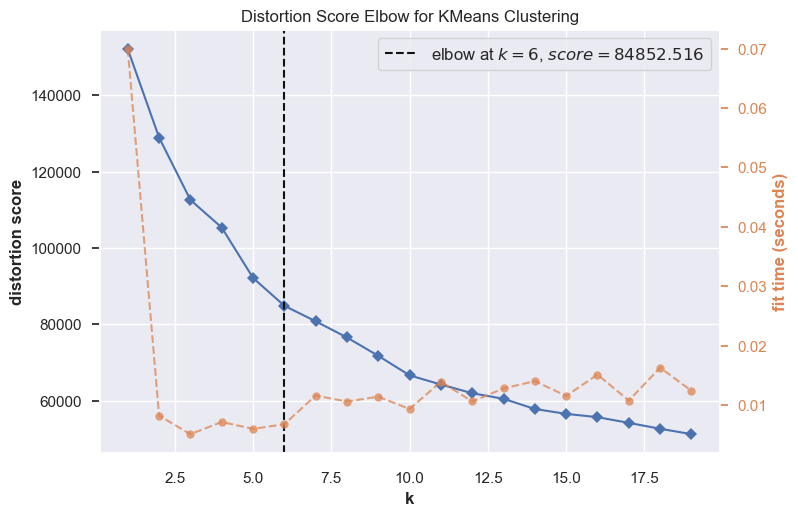

In [16]:
model = KMeans(random_state=42, n_init='auto')
visualizer = KElbowVisualizer(model, k=(1, 20))

visualizer.fit(transformed_df)  # Fit the data to the visualizer
visualizer.show();

- The optimal number of clusters is not as clear as it was in our toy example. 

- Let's examine Silhouette scores.  

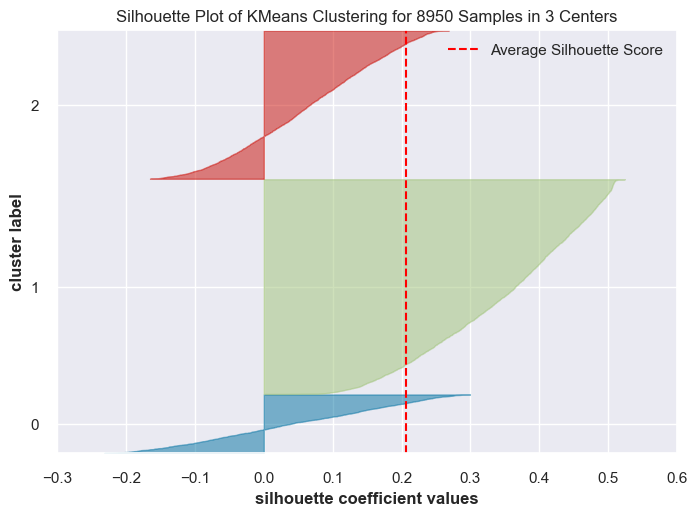

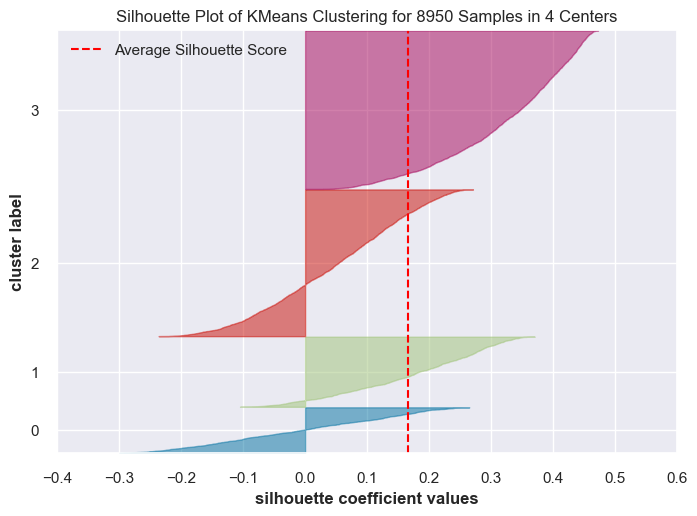

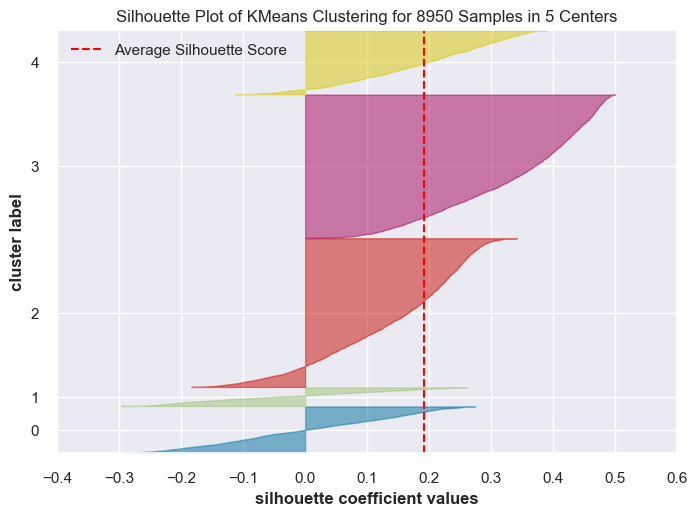

In [17]:
for k in range(3, 6):
    model = KMeans(k, random_state=42)
    visualizer = SilhouetteVisualizer(model, colors="yellowbrick")
    visualizer.fit(transformed_df)  # Fit the data to the visualizer
    visualizer.show()

- I'm going to run `KMeans` with `n_clusters = 4`. 
- You can try out `n_clusters = 5` and `n_clusters = 6` on your own. 

### Visualizing clusters 

- Can we visualize the clusters? 
- We have a high dimensional data and we need to reduce the dimensionality in order to visualize it. 
- Let's reduce the dimensionality using a technique called [UMAP](https://umap-learn.readthedocs.io/en/latest/index.html). 

I forgot to put this package in the course environment file. So to run the code below, you'll have to install the `umap-learn` package in the course conda environment either with `conda` or `pip`, as described in the [documentation](https://umap-learn.readthedocs.io/en/latest/index.html). 

```
> conda activate 563
> conda install -c conda-forge umap-learn
```

or 

```
> conda activate 563
> pip install umap-learn
```


In [18]:
import umap

In [19]:
def plot_umap_clusters(
    data,
    cluster_labels,
    size=50,
    n_neighbors=15,
    title="UMAP visualization",
):
    """
    Carry out dimensionality reduction using UMAP and plot 2-dimensional clusters.

    Parameters
    -----------
    data : numpy array
        data as a numpy array
    cluster_labels : list
        cluster labels for each row in the dataset
    size : int
        size of points in the scatterplot
    n_neighbors : int
        n_neighbors hyperparameter of UMAP. See the documentation.
    title : str
        title for the visualization plot

    Returns
    -----------
    None. Shows the clusters.
    """

    reducer = umap.UMAP(n_neighbors=n_neighbors)
    Z = reducer.fit_transform(data)  # reduce dimensionality
    umap_df = pd.DataFrame(data=Z, columns=["dim1", "dim2"])
    umap_df["cluster"] = cluster_labels

    labels = np.unique(umap_df["cluster"])

    fig, ax = plt.subplots(figsize=(10, 7))
    ax.set_title(title)

    scatter = ax.scatter(
        umap_df["dim1"],
        umap_df["dim2"],
        c=umap_df["cluster"],
        cmap="tab20b",
        s=size,
        edgecolors="k",
        linewidths=0.1,
    )

    legend = ax.legend(*scatter.legend_elements(), loc="best", title="Clusters")
    ax.add_artist(legend)

    plt.show()

/Users/kvarada/miniforge3/envs/563/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



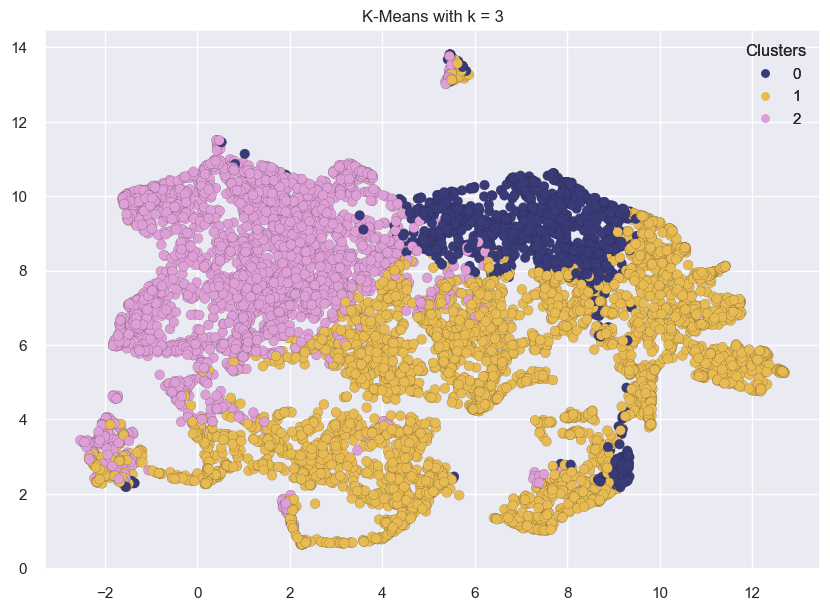

/Users/kvarada/miniforge3/envs/563/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



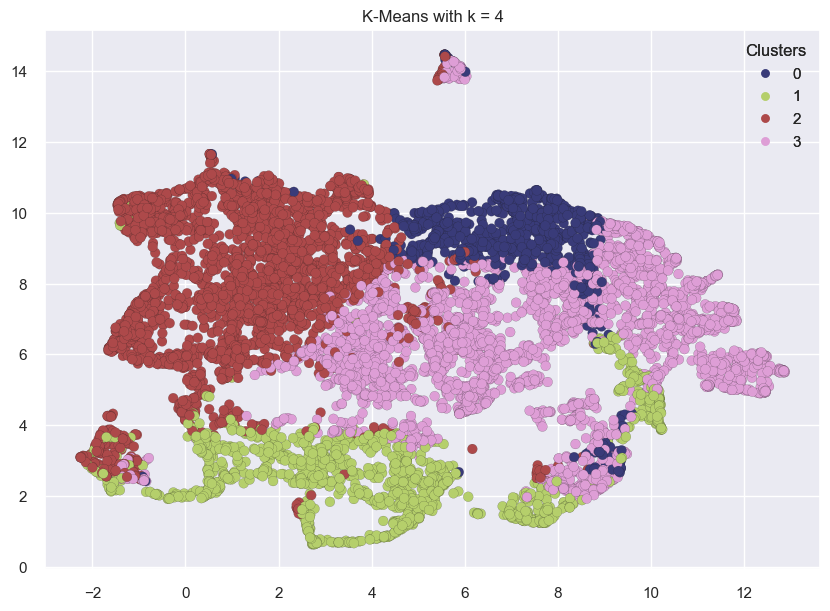

/Users/kvarada/miniforge3/envs/563/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



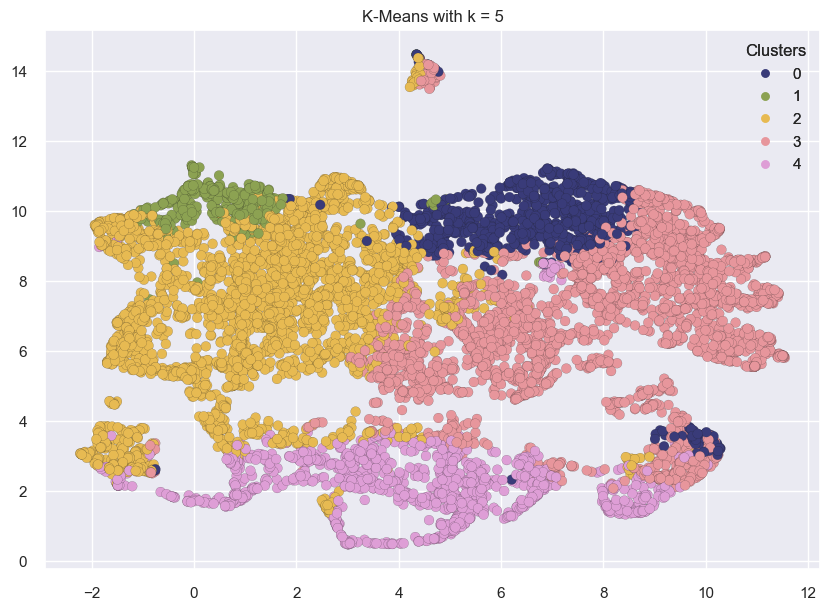

/Users/kvarada/miniforge3/envs/563/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



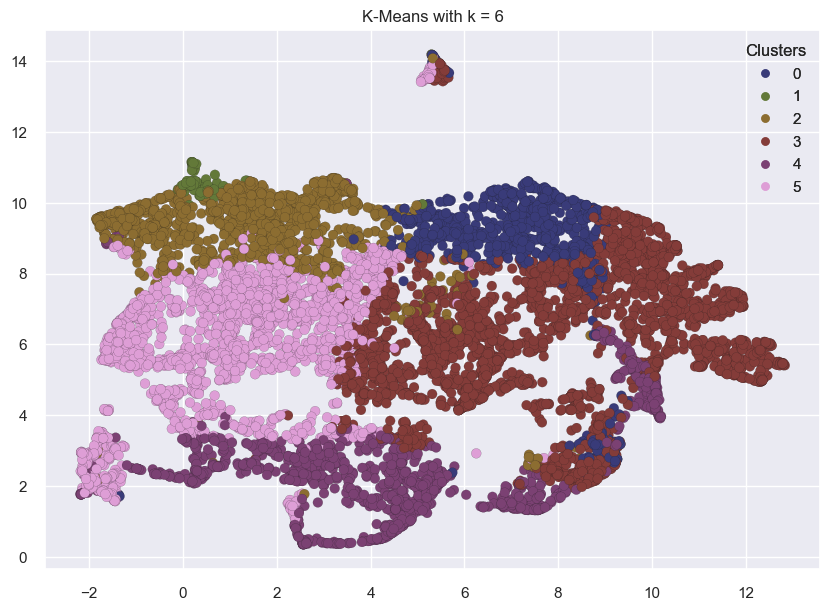

In [20]:
for k in range(3, 7):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(transformed_df)
    labels = kmeans.labels_
    plot_umap_clusters(transformed_df, kmeans.labels_, title=f"K-Means with k = {k}")

- The clusters above look reasonably well separated. 
- This might not always be the case. 

### Cluster interpretation

- Let's examine the cluster centers for k=4 and identify types of customers.  

In [21]:
reasonable_k = 4
kmeans = KMeans(n_clusters=reasonable_k, random_state=42)
kmeans.fit(transformed_df)
labels = kmeans.labels_

In [22]:
cluster_centers = pd.DataFrame(
    data=kmeans.cluster_centers_, columns=[transformed_df.columns]
)
cluster_centers

PURCHASES_TRX INSTALLMENTS_PURCHASES CASH_ADVANCE PURCHASES    TENURE  \
0     -0.171033              -0.157231     1.955351 -0.130672 -0.077145   
1     -0.398135              -0.276859    -0.323962 -0.304986 -0.227297   
2      0.724525               0.585261    -0.354967  0.551465  0.157039   
3     -0.444873              -0.373694    -0.088460 -0.337608 -0.022578   

  CREDIT_LIMIT CASH_ADVANCE_TRX PURCHASES_INSTALLMENTS_FREQUENCY  PAYMENTS  \
0     1.028456         1.846509                        -0.360719  0.844275   
1    -0.238330        -0.368721                        -0.324939 -0.240955   
2     0.172113        -0.357770                         0.965455  0.143300   
3    -0.348272        -0.034898                        -0.645713 -0.267719   

  MINIMUM_PAYMENTS ONEOFF_PURCHASES ONEOFF_PURCHASES_FREQUENCY  \
0         0.587979        -0.082658                  -0.135258   
1        -0.262345        -0.241643                  -0.434756   
2        -0.034300         0.390972                   0.628970   
3        -0.020631        -0.230970                  -0.350561   

  BALANCE_FREQUENCY CASH_ADVANCE_FREQUENCY   BALANCE PRC_FULL_PAYMENT  \
0          0.379847               1.876058  1.668482        -0.388985   
1         -1.959157              -0.499183 -0.699072         0.339213   
2          0.411562              -0.466944 -0.149443         0.441615   
3          0.377251               0.115300 -0.030426        -0.447004   

  PURCHASES_FREQUENCY  
0           -0.398442  
1           -0.421838  
2            1.091535  
3           -0.708633

- Recall that we have applied imputation and scaling on the dataset. 
- But we would be able to interpret these clusters better if the centers are in the original scale. 
- So let's apply inverse transformations to get the cluster center values in the original scale. 

In [23]:
data = (
    preprocessor.named_transformers_["pipeline"]
    .named_steps["standardscaler"]
    .inverse_transform(cluster_centers[numeric_features])
)

In [24]:
org_cluster_centers = pd.DataFrame(data=data, columns=numeric_features)
org_cluster_centers = org_cluster_centers.reindex(
    sorted(org_cluster_centers.columns), axis=1
)
org_cluster_centers

BALANCE  BALANCE_FREQUENCY  CASH_ADVANCE  CASH_ADVANCE_FREQUENCY  \
0  5037.279872           0.967253   5079.333901                0.510563   
1   109.416344           0.413164    299.507902                0.035253   
2  1253.422099           0.974766    234.489319                0.041704   
3  1501.145757           0.966638    793.365530                0.158217   

   CASH_ADVANCE_TRX  CREDIT_LIMIT  INSTALLMENTS_PURCHASES  MINIMUM_PAYMENTS  \
0         15.849896   8236.391869              268.885549       2234.467700   
1          0.732574   3627.308985              160.707741        252.821490   
2          0.807310   5120.665715              940.311888        784.272825   
3          3.010673   3227.295187               73.140602        816.126935   

   ONEOFF_PURCHASES  ONEOFF_PURCHASES_FREQUENCY     PAYMENTS  \
0        455.241325                    0.162108  4177.236119   
1        191.358908                    0.072762  1035.603761   
2       1241.370362                    0.390092  2147.982881   
3        209.074918                    0.097879   958.122729   

   PRC_FULL_PAYMENT    PURCHASES  PURCHASES_FREQUENCY  \
0          0.039943   724.021625             0.330436   
1          0.252929   351.597815             0.321047   
2          0.282880  2181.418772             0.928436   
3          0.022974   281.900172             0.205942   

   PURCHASES_INSTALLMENTS_FREQUENCY  PURCHASES_TRX     TENURE  
0                          0.221079      10.458592  11.414079  
1                          0.235298       4.813673  11.213137  
2                          0.748134      32.718820  11.727477  
3                          0.107815       3.651942  11.487103

In [25]:
cluster_labels = {0: "Transactors", 1: "Revolvers", 2: "Low activity", 3: "VIP/Prime"}
org_cluster_centers["cluster_labels"] = list(cluster_labels.values())

In [26]:
relevant_cols = [
    "cluster_labels",
    "BALANCE",
    "CREDIT_LIMIT",
    "PRC_FULL_PAYMENT",
    "PURCHASES_FREQUENCY",
    "CASH_ADVANCE",
    "CASH_ADVANCE_FREQUENCY",
    "CASH_ADVANCE_TRX",
]
org_cluster_centers[relevant_cols]

cluster_labels      BALANCE  CREDIT_LIMIT  PRC_FULL_PAYMENT  \
0    Transactors  5037.279872   8236.391869          0.039943   
1      Revolvers   109.416344   3627.308985          0.252929   
2   Low activity  1253.422099   5120.665715          0.282880   
3      VIP/Prime  1501.145757   3227.295187          0.022974   

   PURCHASES_FREQUENCY  CASH_ADVANCE  CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  
0             0.330436   5079.333901                0.510563         15.849896  
1             0.321047    299.507902                0.035253          0.732574  
2             0.928436    234.489319                0.041704          0.807310  
3             0.205942    793.365530                0.158217          3.010673

One way to interpret and label the clusters above is as follows. 

#### Transactors
- Credit card users who pay off their balance every month with least amount of interest charges. 
- They are careful with their money. 
- They have lowest balance and cash advance

#### Revolvers
- Credit card users who pay off only part of their monthly balance. They use credit card as a loan.  
- They have highest balance and cash advance, high cash advance frequency, low purchase frequency, high cash advance transactions, low percentage of full payment
- Their credit limit is also high. (Lucrative group for banks 😟.)

#### Low activity
- There is not much activity in the account. It has low balance and not many purchases. 
- Credit card users who have low credit limit.

#### VIP/Prime
- Credit card users who have high credit limit. 
- They have high one-off purchases frequency, high number of purchase transactions. 
- They have high balance but they also have higher percentage of full payment, similar to transactors
- Target for increase credit limit (and increase spending habits)

### More on interpretation of clusters

- In real life, you'll look through all features in detail before assigning meaning to clusters. 
- This is not that easy, especially when you have a large number of features and clusters. 
- One way to approach this would be visualizing the distribution of feature values for each cluster. 
- Some domain knowledge would definitely help at this stage.  

In [27]:
creditcard_df['cluster'] = labels

Let's check the cluster assignment for the customer who made the maximum cash advance transaction. 

In [28]:
creditcard_df[creditcard_df["CASH_ADVANCE"] == max_cash_advance] 

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
2159  C12226  10905.05381                1.0     431.93             133.5   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
2159                  298.43   47137.21176             0.583333   

      ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
2159                        0.25                               0.5   

      CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
2159                     1.0               123             21       19600.0   

         PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  cluster  
2159  39048.59762       5394.173671               0.0      12        0

In [29]:
def show_hists(df=creditcard_df, cols=["BALANCE", "CASH_ADVANCE"]):
    for i in cols:
        plt.figure(figsize=(35, 5))
        for j in range(4):
            plt.subplot(1, 4, j + 1)
            cluster = df[df["cluster"] == j]
            cluster[i].hist(bins=20)
            plt.title(f"{i}    \nCluster: {cluster_labels[j]} ")

        plt.show()

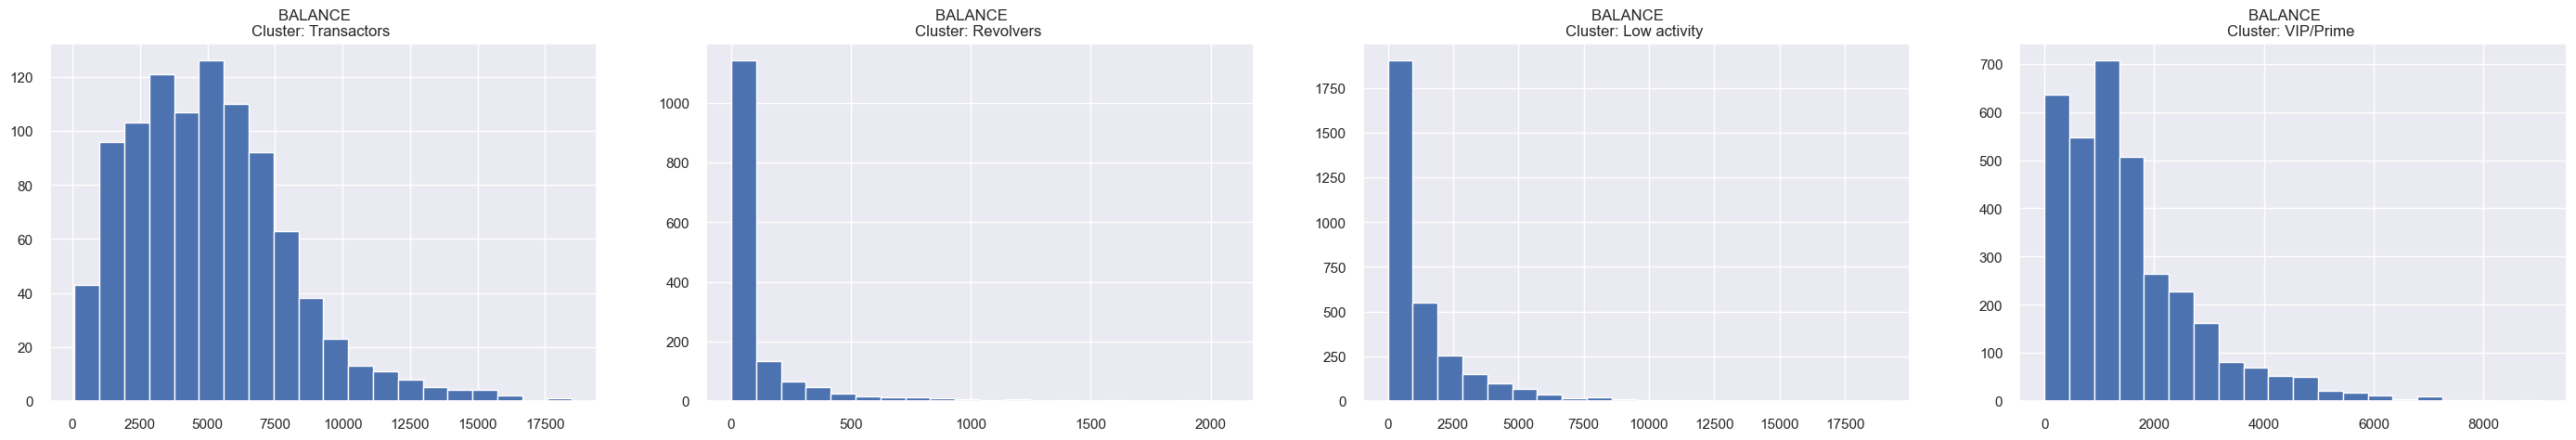

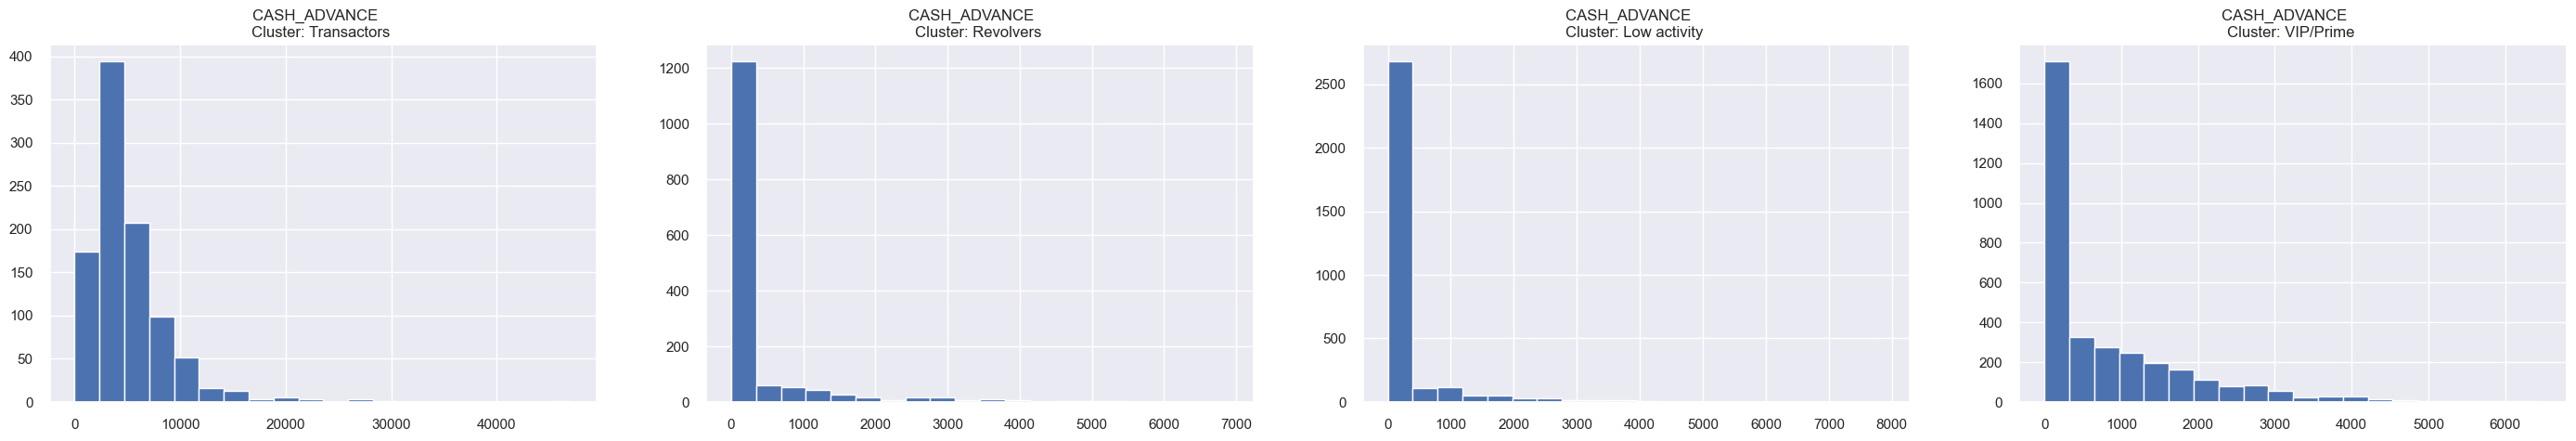

In [30]:
show_hists() # Examining clusters for two features. 

In [31]:
# Uncomment the code below to show histograms for all features. 
# cols = creditcard_df_cluster.columns.to_list()
# cols.remove('CUST_ID')
# cols.remove('cluster')
# show_hists(creditcard_df_cluster, cols)

### Practice exercise for you
- Try out different values for `n_clusters` in `KMeans` and examine the clusters. 
- If you are feeling adventurous, you may try customer segmentation on [All Lending Club loan data](https://www.kaggle.com/wordsforthewise/lending-club). 